# How to use the `abscal` module of `hera_cal`
<br>
Jan. 2018

---

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from pyuvdata import UVData, UVCal
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt

## load a model and data

In [2]:
# specify model file and load into UVData, load into dictionary
model_fname1 = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
model_fname2 = os.path.join(DATA_PATH, "zen.2458042.13298.xx.HH.uvXA")
uvm = UVData()
uvm.read_miriad(model_fname1)
uvm2 = UVData()
uvm2.read_miriad(model_fname2)
uvm += uvm2
model_freqs = np.unique(uvm.freq_array)
model_times = np.unique(uvm.lst_array)
model, mflags = hc.abscal.UVData2AbsCalDict(uvm)

# specify data file and load into UVData, load into dictionary
data_fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
uvd = UVData()
uvd.read_miriad(data_fname)
data_freqs = np.unique(uvd.freq_array)
data_times = np.unique(uvd.lst_array)
data, dflags = hc.abscal.UVData2AbsCalDict(uvd)

# make wgts
wgts = copy.deepcopy(dflags)
for k in wgts.keys():
    wgts[k] = (~wgts[k]).astype(np.float)

# get antenna positions and make baseline directory
antpos, ants = uvd.get_ENU_antpos(pick_data_ants=True, center=True)
antloc = copy.copy(antpos)
antpos = odict(zip(ants, antpos))
bls = odict([(x, antpos[x[1]] - antpos[x[0]]) for x in model.keys()])

(-30, 30)

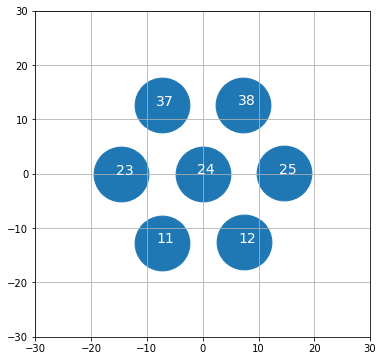

In [3]:
# plot sub-array HERA layout
plt.figure(figsize=(6,6))
plt.grid()
plt.scatter(antloc[:, 0], antloc[:, 1], s=3000)
_ = [plt.text(antloc[i, 0]-1, antloc[i, 1], str(ants[i]), fontsize=14, color='w') for i in range(len(ants))]
plt.xlim(-30, 30)
plt.ylim(-30, 30)

## interpolate model onto time & freq axes of data

In [4]:
model, mflags = hc.abscal.interp2d_vis(model, model_times, model_freqs, data_times, data_freqs)

## plot model and data

divide by zero encountered in log10


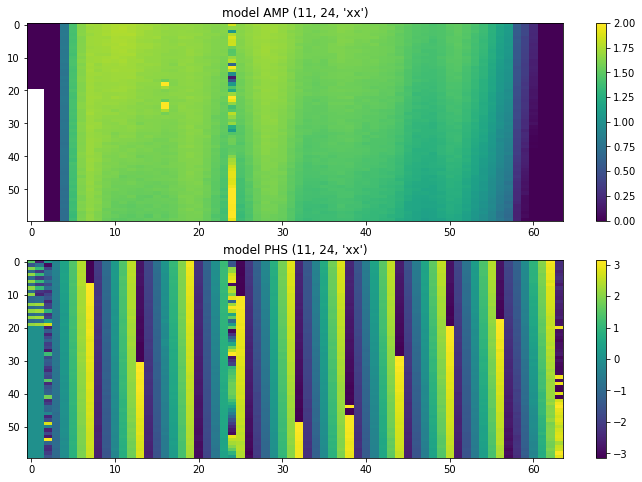

In [5]:
# plot model
bl = (11, 24, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

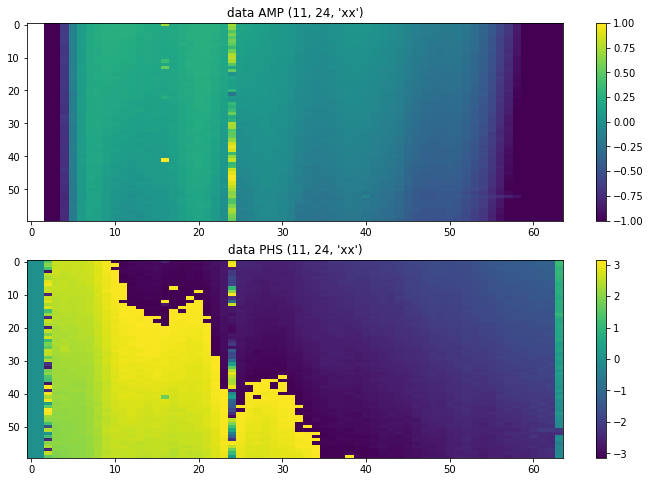

In [6]:
# plot data
bl = (11, 24, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(data[bl], mode='log', mx=1, drng=2)
plt.colorbar()
plt.title('data AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

## Use `hera_cal.abscal.OmniAbsCal` to solve for `omnical` degeneracy modes

In [34]:
# instantiate class
OC = hc.abscal.OmniAbsCal(model, data, antpos, freqs=data_freqs, times=data_times, pols=['xx'])

In [35]:
# run absolute amplitude cal
OC.abs_amp_lincal()

...configuring linsolve data for abs_amp_lincal
...running linsolve
...finished linsolve


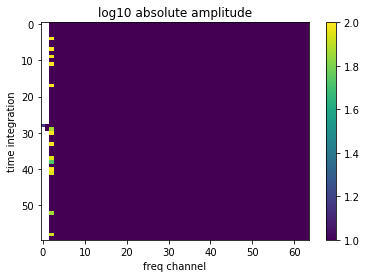

In [36]:
# look at resultant gains
uvt.plot.waterfall(OC.get_abs_amp_gain[0, :, :, 0], mode='log', mx=2, drng=1)
plt.colorbar()
plt.title('log10 absolute amplitude')
plt.xlabel('freq channel')
plt.ylabel('time integration')

In [37]:
# run tip tilt phase slope cal
OC.TT_phs_logcal(zero_psi=True)

...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve


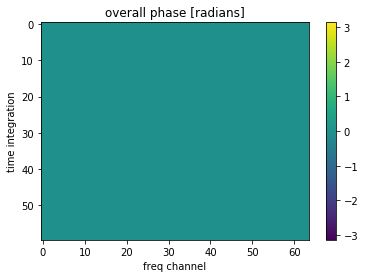

In [38]:
# look at resultant gains
uvt.plot.waterfall(OC.get_abs_psi_gain[0, :, :, 0], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('overall phase [radians]')
plt.xlabel('freq channel')
plt.ylabel('time integration')

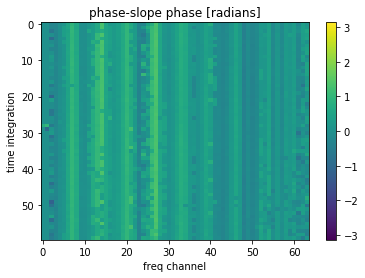

In [39]:
# look at resultant gains
uvt.plot.waterfall(OC.get_TT_Phi_gain[0, :, :, 0], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('phase-slope phase [radians]')
plt.xlabel('freq channel')
plt.ylabel('time integration')

In [40]:
# make full gains
gains = OC.get_abs_amp_gain * OC.get_abs_psi_gain * OC.get_TT_Phi_gain

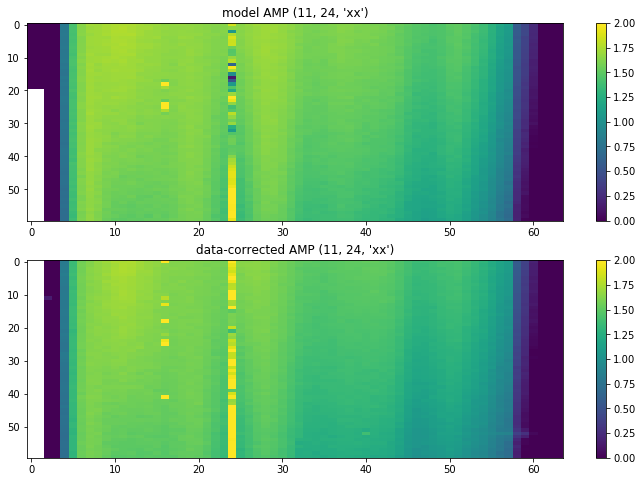

In [41]:
# plot model and data-corrected amplitude
bl = (11, 24, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(data[bl] * (gains[0,:,:,0]*np.conj(gains[3,:,:,0])), mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

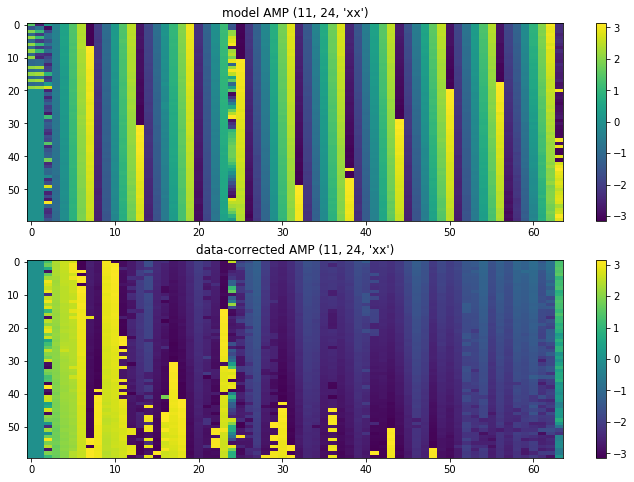

In [44]:
# plot model and data-corrected phase
bl = (11, 24, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(data[bl] * (gains[0,:,:,0]*np.conj(gains[3,:,:,0])), mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

## Use `AbsCal` solvers

In [45]:
AC = hc.abscal.AbsCal(model, data, freqs=data_freqs, times=data_times, pols=['xx'])

In [17]:
# amp solve
AC.amp_logcal()

...configuring linsolve data for amp_logcal
...running linsolve


divide by zero encountered in divide
invalid value encountered in divide


...finished linsolve


In [48]:
# phs solve
AC.phs_logcal()

...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve


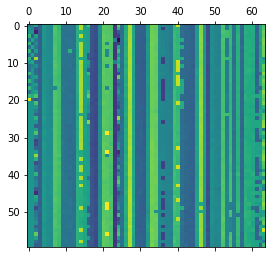

In [50]:
plt.matshow(AC.get_ant_phi[0, :, :, 0])

In [19]:
gains = AC.get_ant_eta_gain * AC.get_ant_phi_gain

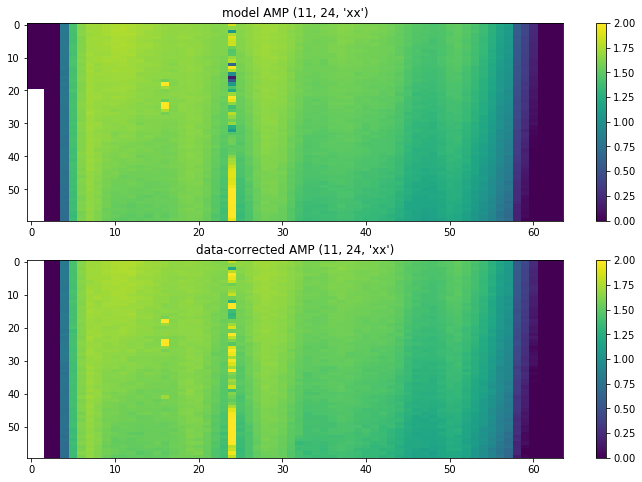

In [33]:
# plot model and data-corrected amplitude
bl = (11, 24, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(data[bl] * (gains[0,:,:,0]*np.conj(gains[3,:,:,0])), mode='log', mx=2, drng=2)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

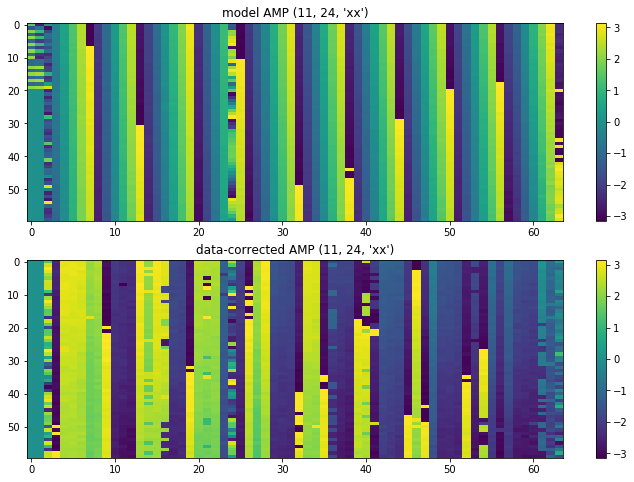

In [26]:
# plot model and data-corrected phase
bl = (11, 24, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(data[bl] * (gains[0,:,:,0]*np.conj(gains[3,:,:,0])), mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))